# Wave-Glider analysis

This is the python version of what is done int this notebook [Studying_waves.ipynb][def]

[def]: Studying_waves.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt, detrend

In [2]:
import importlib
from stat_wave_1D import stat_wave_1D, fast_psd
# importlib.reload(stat_wave_1D)


In [3]:
glider = pd.read_csv('../data/Cleaned_Combined_Data.csv', parse_dates=['Timestamp'])  # automatically uses the first row as header
orcasim = pd.read_csv('../data/OffshoreTestSurrogateSims.csv'); 

In [4]:
glider[1:3]

,Timestamp,Quad[0],Quad[1],Quad[2],Quad[3],PQR[0],PQR[1],PQR[2],ACC[0],ACC[1],ACC[2],Euler[0],Euler[1],Euler[2]
1,2025-02-13 08:05:15.171,0.42275,0.17345,-0.06288,0.88727,-0.07495,-0.04282,0.03635,-3.15955,8.90044,-0.23389,2.01335,-21.09387,128.71100
2,2025-02-13 08:05:15.269,0.42217,0.17087,-0.06451,0.88793,-0.05630,-0.03247,0.03191,-3.18040,8.90886,-0.27861,1.74466,-20.91110,128.84535


In [5]:
orcasim[1:3]

,Time,X,Y,Z,Surge,Sway,Heave,Roll,Pitch,Yaw,...,ACCz,PQRx,PQRy,PQRz,x velocity,y velocity,z velocity,x angular velocity,y angular velocity,z angular velocity
1,-7.9,-5.330000e-07,-0.000001,-0.399998,-5.330000e-07,-0.000001,0.000002,-9.600000e-07,-1.370000e-07,4.520000e-07,...,0.002724,-0.000016,-0.000003,0.000010,-0.000022,-0.000062,0.000097,-6.630000e-07,-1.010000e-07,3.350000e-07
2,-7.8,-6.290000e-06,-0.000020,-0.399968,-6.290000e-06,-0.000020,0.000032,-1.030000e-05,-1.870000e-06,6.490000e-06,...,0.006755,-0.000021,-0.000006,0.000024,-0.000099,-0.000341,0.000568,-2.670000e-06,-5.570000e-07,2.010000e-06


## Glider data only

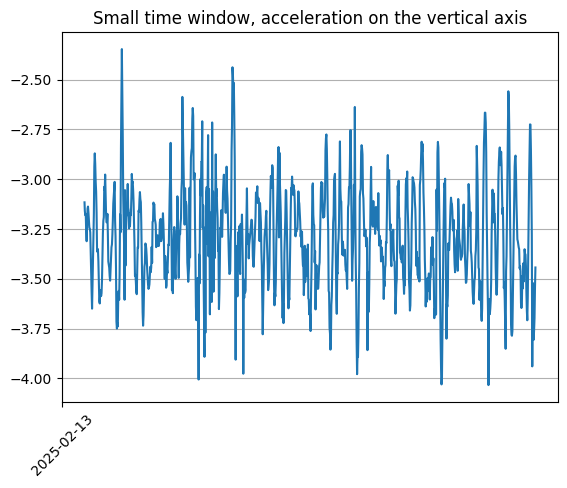

In [6]:
import matplotlib.dates as mdates
real_time= glider['Timestamp'].values

plt.plot(real_time[:1000], glider['ACC[0]'][:1000])
plt.xticks(rotation=45)
plt.title('Small time window, acceleration on the vertical axis')
# Format x-axis ticks to show month and day
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # e.g., "Feb 13"
# # Optional: set major ticks every few days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.grid()
plt.show()

### Dominant Height and wave period

Significant Wave Height Hs: 1.1201188064262608 meters
Dominant Frequency: 0.107421875 Hz
Peak Period: 9.309090909090909 seconds


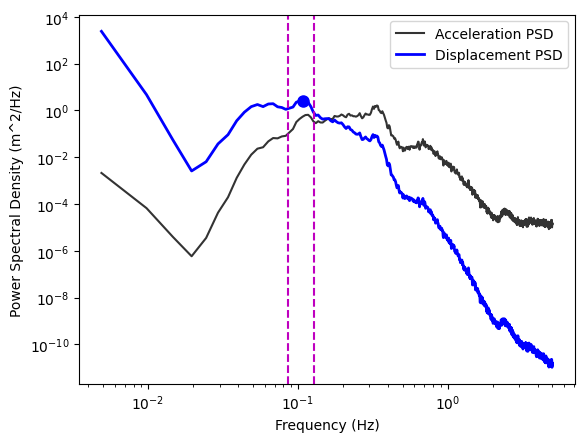

In [7]:
f_min = 0.05  # Minimum frequency to consider (Hz)
f_max = 10.0  # Maximum frequency to consider (Hz)
fs = 10.0  # Sampling frequency (Hz)
fc = 0.05 # cutoff frequency for filtering high pass

ac = glider['ACC[0]'] < -7.5      #remove when glider is not vertical
data = glider['ACC[0]'][ac] 

results = stat_wave_1D(data, fs, fc,  f_min, f_max)



## Model data

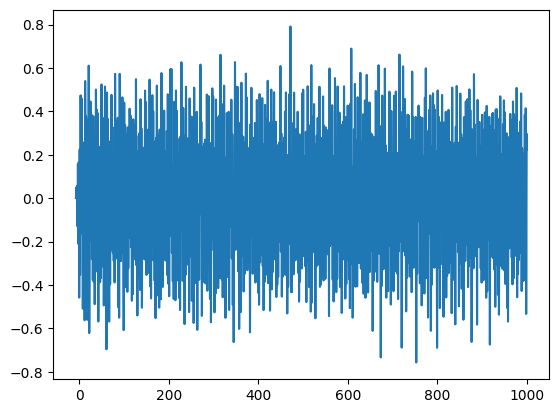

In [8]:
plt.plot(orcasim['Time'], orcasim['ACCz'])


Significant Wave Height Hs: 0.6685063598232025 meters
Dominant Frequency: 0.05859375 Hz
Peak Period: 17.066666666666666 seconds


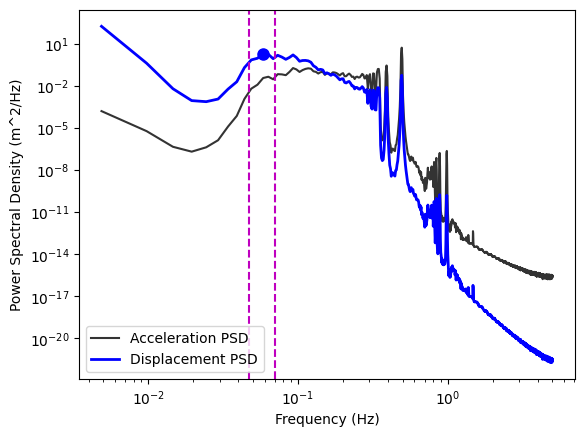

In [9]:
f_min = 0.05  # Minimum frequency to consider (Hz)
f_max = 10.0  # Maximum frequency to consider (Hz)
fs = 10.0  # Sampling frequency (Hz)
fc = 0.05 # cutoff frequency for filtering high pass

data = orcasim['ACCz']
results_sim = stat_wave_1D(data, fs, fc, f_min, f_max)

This is very interesting. The simulation that a much longer period 17 seconds!

The figure above showcases how to estimate the signfinican wave height and the dominant wave frequency from the glider heave. 


In [10]:
results

{'P_eta': array([2.40749435e+03, 4.72201744e+00, 5.49770177e-02, ...,
        1.60588981e-11, 1.32042105e-11, 1.50473336e-11]),
 'k': array([4.88281250e-03, 9.76562500e-03, 1.46484375e-02, ...,
        4.99023438e+00, 4.99511719e+00, 5.00000000e+00]),
 'a_z_filtered': array([ 0.12486589, -0.29564033, -0.81432432, ..., -0.02357626,
         0.0123786 ,  0.11605929]),
 'H_s': np.float64(1.1201188064262608),
 'f_peak': np.float64(0.107421875),
 'T_peak': np.float64(9.309090909090909),
 't': array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 4.0826e+03, 4.0827e+03,
        4.0828e+03])}

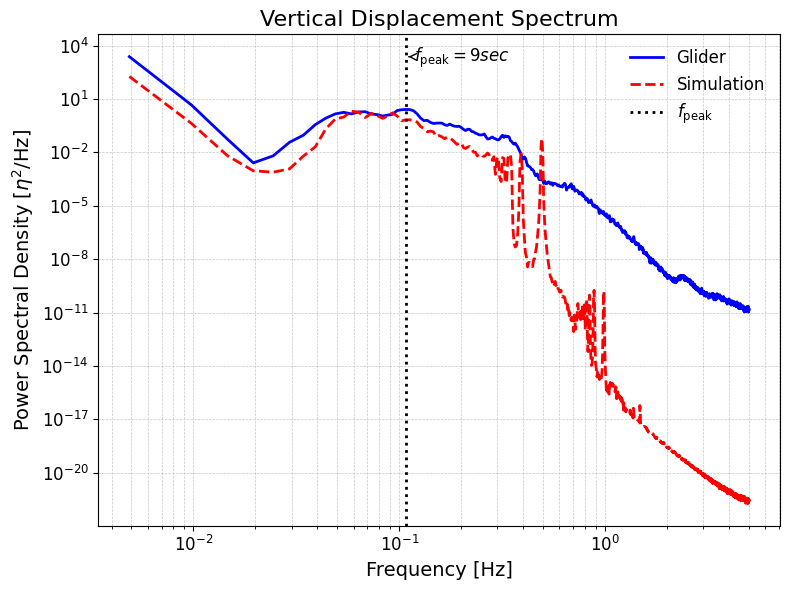

In [11]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the spectral densities
ax.plot(results['k'], results['P_eta'], label='Glider', color='blue', linewidth=2)
ax.plot(results_sim['k'], results_sim['P_eta'], label='Simulation', color='red', linestyle='--', linewidth=2)
ax.set_xscale('log')
ax.set_yscale('log')

# Vertical line for f_peak
f_peak = results['f_peak']
ax.axvline(x=f_peak, color='black', linestyle=':', linewidth=2, label=r'$f_{\mathrm{peak}}$')

# Annotate the vertical line
ax.annotate(r'$f_{\mathrm{peak}} = 9 sec$',  xy=(f_peak, max(results['P_eta'])), xytext=(f_peak * 1.1, max(results['P_eta']) * 0.5),
            textcoords='data',
            arrowprops=dict(arrowstyle="->   ", color='black'),
            fontsize=12)

ax.set_xlabel(r'Frequency [Hz]', fontsize=14)
ax.set_ylabel(r'Power Spectral Density [$\eta^2$/Hz]', fontsize=14)
ax.set_title('Vertical Displacement Spectrum', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(fontsize=12, loc='best', frameon=False)
plt.tight_layout()
plt.show()


### Spectra from all acelerations



In [27]:
# data
ac = glider['ACC[0]'] < -7.5      #remove when glider is not vertical


data = glider['ACC[1]'][ac] 
results_y = stat_wave_1D(data, fs, fc,  f_min, f_max, make_figure = False)
data = glider['ACC[2]'][ac] 
results_x = stat_wave_1D(data, fs, fc,  f_min, f_max, make_figure = False)

# Simulations
data = orcasim['ACCx']
results_sim_x = stat_wave_1D(data, fs, fc, f_min, f_max, make_figure = False)
data = orcasim['ACCy']
results_sim_y = stat_wave_1D(data, fs, fc, f_min, f_max, make_figure = False)



Significant Wave Height Hs: 2.379631042266558 meters
Dominant Frequency: 0.185546875 Hz
Peak Period: 5.389473684210526 seconds
Significant Wave Height Hs: 2.2027855360619055 meters
Dominant Frequency: 0.21484375 Hz
Peak Period: 4.654545454545454 seconds
Significant Wave Height Hs: 0.5142385840548122 meters
Dominant Frequency: 0.05859375 Hz
Peak Period: 17.066666666666666 seconds
Significant Wave Height Hs: 0.6892027733571227 meters
Dominant Frequency: 0.0732421875 Hz
Peak Period: 13.653333333333334 seconds


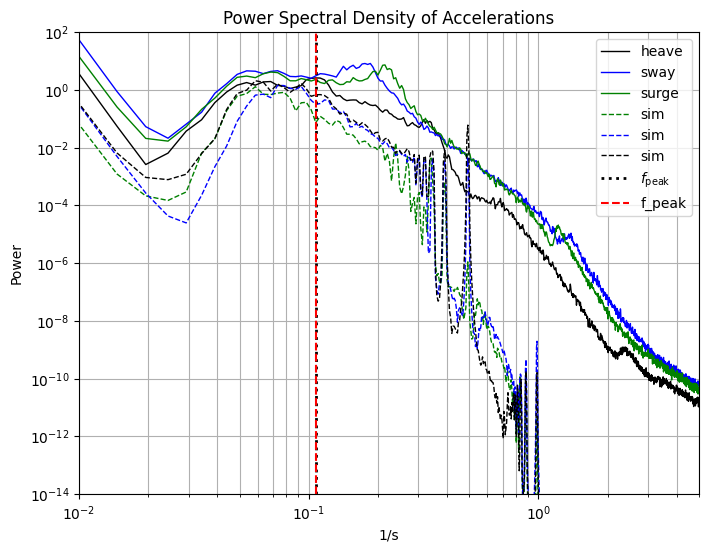

In [65]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(results['k'], results['P_eta'], label='heave', color='black', linewidth=1)
plt.plot(results_y['k'], results_y['P_eta'], label='sway', color='blue', linewidth=1)
plt.plot(results_x['k'], results_x['P_eta'], label='surge', color='green', linewidth=1)

plt.plot(results_sim_x['k'], results_sim_x['P_eta'], label='sim', color='green', linewidth=1, linestyle='--')
plt.plot(results_sim_y['k'], results_sim_y['P_eta'], label='sim', color='blue', linewidth=1, linestyle='--') 
plt.plot(results_sim['k'], results_sim['P_eta'], label='sim', color='black', linewidth=1, linestyle='--') 

ax.set_xscale('log')
ax.set_yscale('log')

# Vertical line for f_peak
f_peak = results['f_peak']
ax.axvline(x=f_peak, color='black', linestyle=':', linewidth=2, label=r'$f_{\mathrm{peak}}$')

plt.axvline(x=results['f_peak'], color='r', linestyle='--', label='f_peak')  # vertical line

plt.xlabel('1/s')               # X-axis label
plt.ylabel('Power')            # Optional Y-axis label
plt.grid(True, which='both')   # Turn on grid for both major and minor ticks
plt.legend()                   # Add legend
plt.title('Power Spectral Density of Accelerations')  # Add title
# plt.tight_layout()             # Improve spacing
plt.xlim([0.01, 5])            # Set x-axis limits
plt.ylim([1e-14, 1e2])            # Set y-axis limits
plt.show()


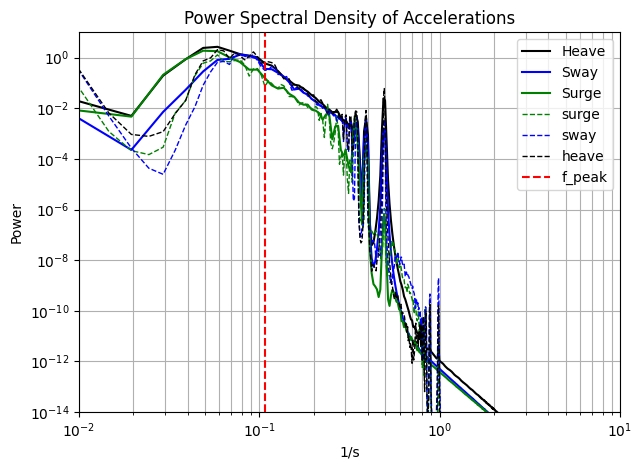

In [ ]:
# Angular velocity (rad/s)
P, k = fast_psd(orcasim['Heave'], 2**10, 10)  # heave (z) up-down motion
P2, _ = fast_psd(orcasim['Sway'], 2**10, 10) # surge (y) forwrd-backward motion
P3, _ = fast_psd(orcasim['Surge'], 2**10, 10) # sway (x) side-to-side motion

plt.loglog(k, P, label='Heave', color = 'black')
plt.loglog(k, P2, label='Sway', color = 'blue')
plt.loglog(k, P3, label='Surge', color = 'green')

plt.loglog(results_sim_x['k'], results_sim_x['P_eta'], label='surge', color='green', linewidth=1, linestyle='--')
plt.loglog(results_sim_y['k'], results_sim_y['P_eta'], label='sway', color='blue', linewidth=1, linestyle='--') 
plt.loglog(results_sim['k'], results_sim['P_eta'], label='heave', color='black', linewidth=1, linestyle='--') 



plt.axvline(x=results['f_peak'], color='r', linestyle='--', label='f_peak')  # vertical line

plt.xlabel('1/s')               # X-axis label
plt.ylabel('Power')            # Optional Y-axis label
plt.grid(True, which='both')   # Turn on grid for both major and minor ticks
plt.legend()                   # Add legend
plt.title('Power Spectral Density of Accelerations')  # Add title
plt.tight_layout()             # Improve spacing
plt.xlim([0.01, 10])            # Set x-axis limits
plt.ylim([1e-14, 1e1])            # Set y-axis limits
plt.show()


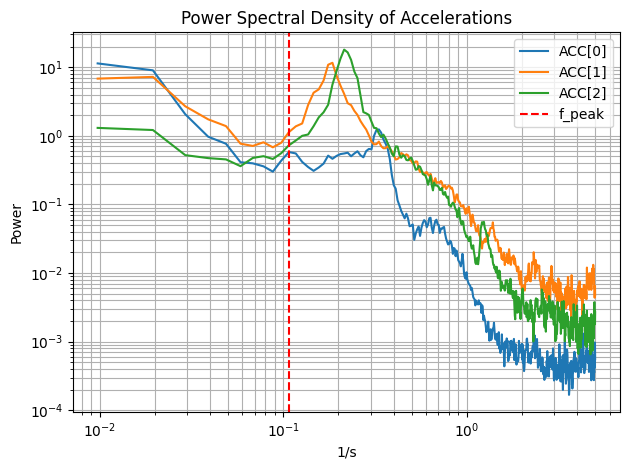

In [63]:
# fast_psd(x, nfft_in, fs):

# Angular velocity (rad/s)
P, k = fast_psd(glider['ACC[0]'], 2**10, 10)  # heave (z) up-down motion
P2, _ = fast_psd(glider['ACC[1]'], 2**10, 10) # surge (y) forwrd-backward motion
P3, _ = fast_psd(glider['ACC[2]'], 2**10, 10) # sway (x) side-to-side motion



plt.loglog(k, P, label='ACC[0]')
plt.loglog(k, P2, label='ACC[1]')
plt.loglog(k, P3, label='ACC[2]')

plt.axvline(x=results['f_peak'], color='r', linestyle='--', label='f_peak')  # vertical line

plt.xlabel('1/s')               # X-axis label
plt.ylabel('Power')            # Optional Y-axis label
plt.grid(True, which='both')   # Turn on grid for both major and minor ticks
plt.legend()                   # Add legend
plt.title('Power Spectral Density of Accelerations')  # Add title
plt.tight_layout()             # Improve spacing
plt.show()


This is very interesting, In the aceleration, the peak is at 9 seconds (red line) this period souns logical with what the Buoy was seing. In the aceleration it seems that the frequency is at 5 secods. a bit smaller so maybe is the double?

In [ ]:
# Angular velocity (rad/s)
P, k = fast_psd(glider['PQR[0]'], 2**10, 10)
P2, _ = fast_psd(glider['PQR[1]'], 2**10, 10)
P3, _ = fast_psd(glider['PQR[2]'], 2**10, 10)

# Coherences

Following the advice of Rose, we are calcualting Euler angles from the velocity:

*But in 3D, when the body is rotating around all 3 axes, and the reference frame is rotating with the body, things get complicated because:*
1. The axes themselves are changing direction!

1. So you need to account for how the rotation in one axis affects the orientation of the others.

This is why we need to use the transformation matrix  $T^{-1} (\phi, \theta)$ to relate angular velocity to the Euler angle rates

In [36]:
import numpy as np
from scipy.integrate import solve_ivp

In [78]:
# dealing with time
# Convert real timestamps to seconds since the first one
ts = (real_time[ac] - real_time[ac][0]) /np.timedelta64(1, 's')
print(ts.size)
dt = np.diff(ts)
# forcing a even dt time
dt_e = 1/10
time_e = np.arange(0, ts.size*dt_e, dt_e)
print(time.size)


40829
40829


In [ ]:
# Loading the data

ac = glider['ACC[0]'] < -7.5     # remove when glider is not vertical

# acelerations
heave = glider['ACC[0]'][ac] # heave (z) up-down motion
surge = glider['ACC[1]'][ac] # surge (y) forwrd-backward motion
sway = glider['ACC[2]'][ac] # sway (x) Side-to-side motion

# Angular velocity (rad/s)
omega_z = np.array(glider['PQR[0]'][ac]) 
omega_y = np.array(glider['PQR[1]'][ac])
omega_x = np.array(glider['PQR[2]'][ac])

In [ ]:
plt.plot(ts, np.rad2deg(omega_x), '.', label='omega_x')

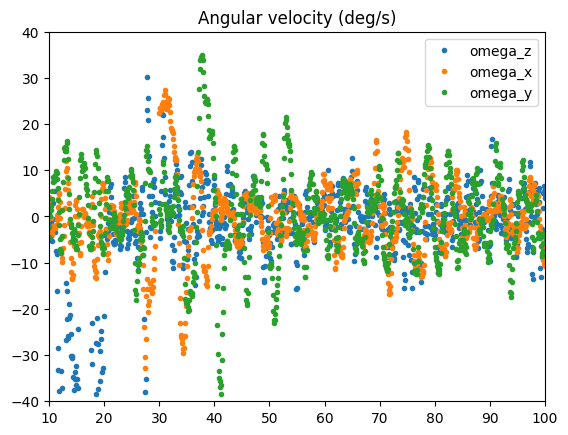

In [171]:
plt.plot(ts, np.rad2deg(omega_z), '.', label='omega_z')
plt.plot(ts, np.rad2deg(omega_x), '.', label='omega_x')
plt.plot(ts, np.rad2deg(omega_y), '.', label='omega_y')
plt.xlim([10, 100])
plt.ylim([-40, 40])
plt.title('Angular velocity (deg/s)')
plt.legend()

In [177]:

def highpass_filter(data, cutoff=0.1, fs=10, order=4):
    b, a = butter(order, cutoff / (0.5 * fs), btype='high', analog=False)
    return filtfilt(b, a, data)

# Apply before integration
ao = np.mean(omega_x)
bo = np.mean(omega_y)
co = np.mean(omega_z)

omega_xf = highpass_filter(omega_x-ao)
omega_yf = highpass_filter(omega_y-bo)
omega_zf = highpass_filter(omega_z-co)



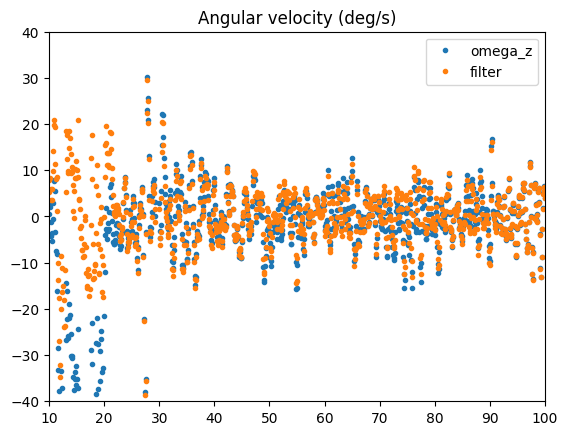

In [178]:
plt.plot(ts, np.rad2deg(omega_z), '.', label='omega_z')
plt.plot(ts, np.rad2deg(omega_zf), '.', label='filter')

plt.xlim([10, 100])
plt.ylim([-40, 40])
plt.title('Angular velocity (deg/s)')
plt.legend()

In [189]:
# Euler angles (deg)
psi = np.zeros_like(ts)  # Yaw
theta = np.zeros_like(ts) # Pitch
phi = np.zeros_like(ts) # Roll

for i in range(1, len(ts)):
    phi_i = phi[i-1]
    theta_i = theta[i-1]

    if np.isclose(np.cos(theta_i), 0):
        continue

    # Inverse transformation matrix T^{-1}(phi, theta)
    T_inv = np.array([
        [1, np.sin(phi_i)*np.tan(theta_i), np.cos(phi_i)*np.tan(theta_i)],
        [0, np.cos(phi_i), -np.sin(phi_i)],
        [0, np.sin(phi_i)/np.cos(theta_i), np.cos(phi_i)/np.cos(theta_i)]
    ])

    # Angular velocity vector at time i-1
    omega_vec = np.array([omega_x[i-1], omega_y[i-1], omega_z[i-1]])

    # Euler angle rates
    euler_dot = T_inv @ omega_vec

    # Integrate
    phi[i] = phi[i-1] + euler_dot[0] * dt[i-1]
    theta[i] = theta[i-1] + euler_dot[1] * dt[i-1]
    psi[i] = psi[i-1] + euler_dot[2] * dt[i-1]  

def wrap_to_180(angle_rad):
    return (angle_rad + np.pi) % (2 * np.pi) - np.pi

phi_ = wrap_to_180(phi)
theta = wrap_to_180(theta)
psi = wrap_to_180(psi)

In [183]:
gimbal_lock_idx = np.where(np.abs(theta) > np.deg2rad(85))[0]
print("Potential gimbal lock steps:", gimbal_lock_idx)

Potential gimbal lock steps: [11209 11210 11211 ... 40822 40823 40824]


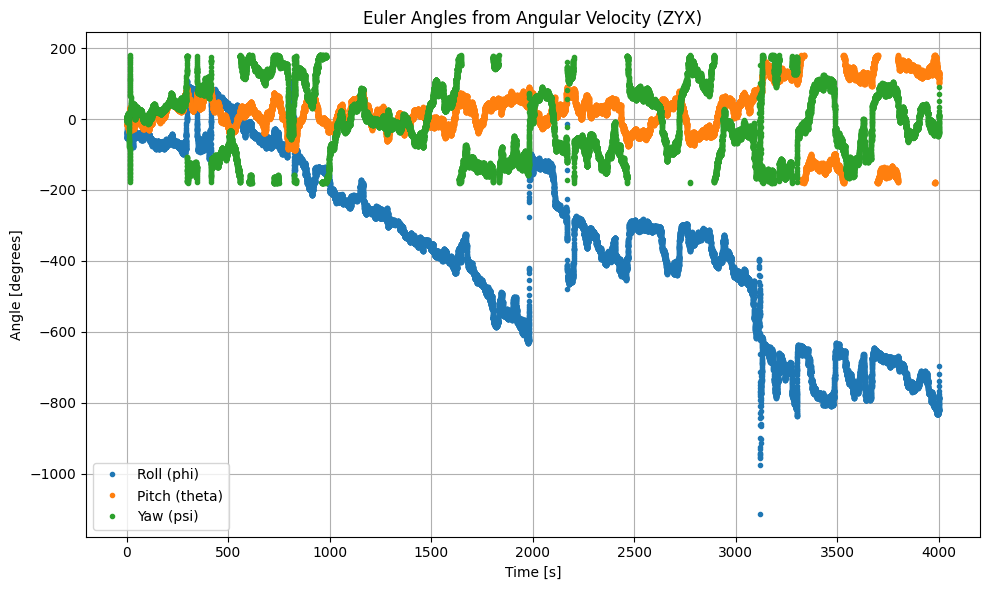

In [191]:
# ---- 4. Plot Euler angles ----
plt.figure(figsize=(10, 6))
plt.plot(ts, np.rad2deg(phi),'.' ,label='Roll (phi)')
plt.plot(ts, np.rad2deg(theta),'.', label='Pitch (theta)')
plt.plot(ts, np.rad2deg(psi),'.', label='Yaw (psi)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [degrees]')
plt.title('Euler Angles from Angular Velocity (ZYX)')
# plt.ylim([-200, 200])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [146]:
print("dt estimate:", np.mean(np.diff(t_seconds)))


dt estimate: 97999673 nanoseconds
